## Loading the CIFAR-10 dataset

In [39]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Data analysis and preprocessing

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

In [41]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [42]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [43]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


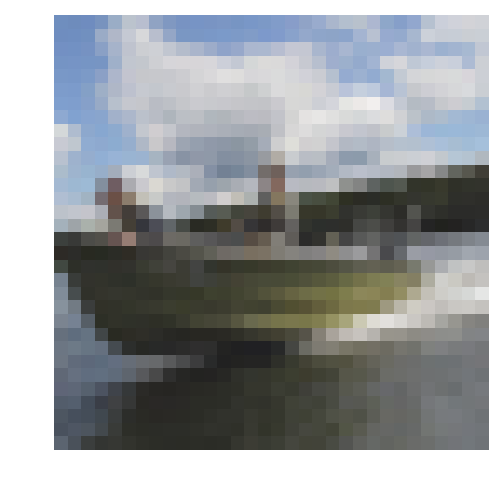

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore a specific batch and sample from the dataset
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### Apply normalization and 1-hot encoding to dataset

In [45]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [46]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [47]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [48]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-pac

In [49]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Model Building

In [50]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [51]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [52]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [53]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [54]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [55]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [56]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [58]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

In [59]:
test_conv_net(build_convolution_net)

Neural Network Built!


## Training Model

In [60]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [61]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [62]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [63]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [64]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1814.883545
Valid accuracy: 0.078125
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1709.524658
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1484.504395
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1036.063110
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1024.843018
Valid accuracy: 0.093750
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1011.904236
Valid accuracy: 0.195312
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1284.112061
Valid accuracy: 0.085938
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 862.213440
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 750.858521
Valid accuracy: 0.242188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 707.073730
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch 

In [ ]:
model_save_path = './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save_path)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1396.495117
Valid accuracy: 0.148438
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1035.165039
Valid accuracy: 0.101562
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1138.301636
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1246.198364
Valid accuracy: 0.109375
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1058.273438
Valid accuracy: 0.164062
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 882.904236
Valid accuracy: 0.164062
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 808.178101
Valid accuracy: 0.148438
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 808.003296
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 888.444946
Valid accuracy: 0.101562
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 857.754028
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 791.083984
Valid accuracy: 0.125000
Epoch number 1, 

## Testing the model

In [66]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [67]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6261942675159236



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


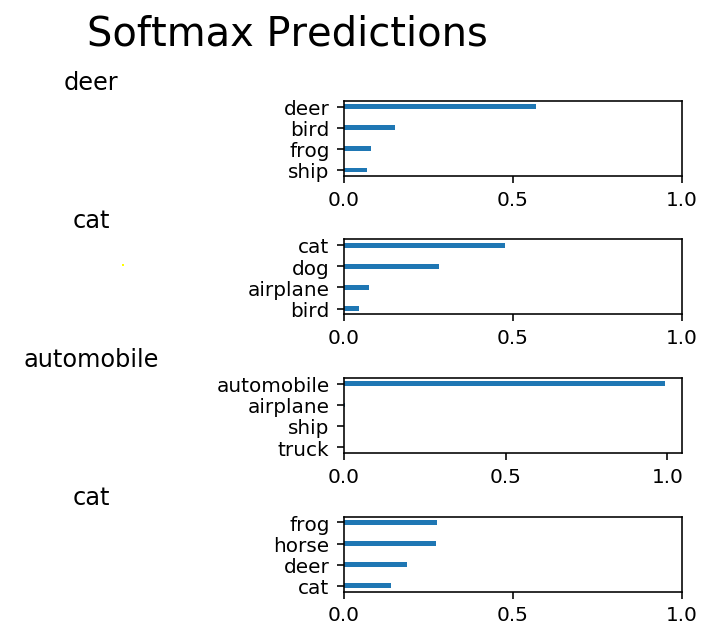

In [68]:
#Calling the function
test_classification_model()

#### By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achieve accuracy of more than 60% which is quite good.